In [183]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [184]:
# Load the .arff file
loaded = arff.loadarff('../connect-4.arff')

# Convert to a numpy array
data = np.asarray(loaded[0].tolist(), dtype=np.float32)

# Print the array
print(data)

[[0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 2.]
 ...
 [2. 2. 0. ... 0. 0. 1.]
 [2. 1. 0. ... 2. 0. 0.]
 [2. 1. 1. ... 0. 0. 0.]]


In [185]:
X = data[:, :-1]
y = data[:, -1:]

# quick fix to make y be 0 or 1
y = np.where(y == 2, 1, 0)

In [186]:
# split into one-hot encoding
X_one_hot = np.where(X == 1, 1, 0), np.where(X == 2, 1, 0)
X = np.hstack(X_one_hot)

# regular train-test split algorithm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)

X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

(60801, 84)


In [187]:
def sigmoid(z):
    return np.clip(1 / (1 + np.exp(-z)), 1e-8, 1 - 1e-8)

def hypothesis(X, w):
    return sigmoid(np.dot(X, w))

def log_likelihood(X: np.ndarray, y: np.ndarray, w: np.ndarray, lam: float):
    preds = hypothesis(X, w)
    term1 = y * np.log(preds)
    term2 = (1-y) * np.log(1-preds)
    combined = term1 + term2
    return np.ndarray.sum(combined) - np.ndarray.sum(abs(w)) * lam

def predict_class(X, w, t):
    hyp = hypothesis(X, w)
    return np.where(hyp >= t, 1, 0)

def precision_recall(X, w, y, t):
    y_hat = predict_class(X, w, t)

    # Calculate false positive and false negative
    # HINT: if done correctly, false_pos should be 1 and false_neg should be 1
    false_pos = np.where(y - y_hat == -1, 1, 0).sum()
    false_neg = np.where(y - y_hat == 1, 1, 0).sum()

    # Calculate true positive and true negatives
    # HINT: if done correctly, true_pos should be 88
    true_pos = np.where(y + y_hat == 2, 1, 0).sum()

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    return precision, recall

def f1_score(X, w, y, t):
        precision, recall = precision_recall(X, w, y, t)
        return (2 * precision * recall) / (precision + recall)

def Gradient_Ascent(X, y, learning_rate, num_iters, lam, threshold=0.5):
    w = np.zeros((X.shape[1],1))
    
    scores = []
    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        hyp = hypothesis(X, w)
        gradient = np.dot(X.T, y - hyp) - lam * np.sign(w)
        w += learning_rate * gradient

        if i % 10 == 0:
            scores.append(f1_score(X, w, y, threshold))
        
    return w, scores

In [188]:
learning_rate = 0.00001
num_iters = 1000
l1_lambda = 1
poly_dim = 1

# transformation
poly = preprocessing.PolynomialFeatures(poly_dim)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

w, scores = Gradient_Ascent(X_train, y_train, learning_rate, num_iters, l1_lambda, 0.56)

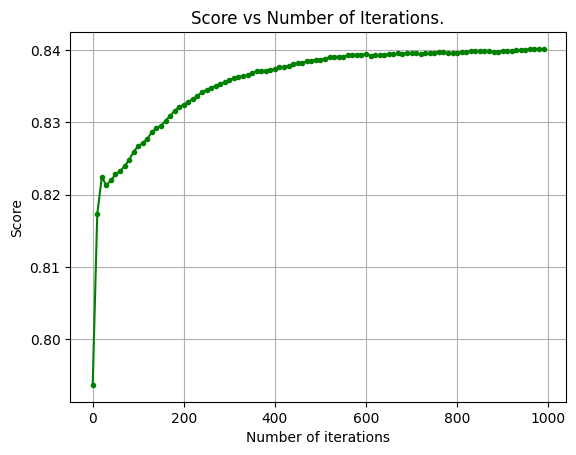

In [189]:
iters = np.array(range(0,num_iters,10))
plt.plot(iters,scores,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Score')
plt.title("Score vs Number of Iterations.")
plt.grid()
plt.show(block=False)

In [190]:
print('log likelihood training:', log_likelihood(X_train, y_train, w, l1_lambda))
print('avg log likelihood:     ', log_likelihood(X_train, y_train, w, l1_lambda) / X_train.shape[0])

print('log likelihood test:    ', log_likelihood(X_test, y_test, w, l1_lambda))
print('avg log likelihood:     ', log_likelihood(X_test, y_test, w, l1_lambda) / X_test.shape[0])
print()

y_hat = predict_class(X_test, w, 0.56)
false_pos = np.where(y_test - y_hat == -1, 1, 0).sum()
false_neg = np.where(y_test - y_hat == 1, 1, 0).sum()
true_pos = np.where(y_test + y_hat == 2, 1, 0).sum()
print('false pos:              ', false_pos)
print('false neg:              ', false_neg)
print('true pos:               ', true_pos)
print()

precision, recall = precision_recall(X_test, w, y_test, 0.56)
print('precision:              ', precision)
print('recall:                 ', recall)
print('f1_score:               ', f1_score(X_test, w, y_test, 0.3))

log likelihood training: -26910.5269878939
avg log likelihood:      -0.4426000721681206
log likelihood test:     -3008.7090633262014
avg log likelihood:      -0.44533881932004166

false pos:               711
false neg:               720
true pos:                3765

precision:               0.8411528150134048
recall:                  0.8394648829431438
f1_score:                0.8394557823129253
